# Humpback Whale Identification

Hey there, after skimming through the provided links, I decided to do this task, Humpback Whale Identification.

## Task

The task is to identify each of the 3,000+ using only the provided images of their flukes

## Data exploration

Firstly, I would like to see first how the data look like and as expected, it comes with extremely high variety in terms of shape, lighting condition, angle etc.

To start, lets see first the distribution of our data for each whale. There are in total of 9,850 training images.

### Distribution of each examples per whale identity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
annotation = pd.read_csv("train.csv", index_col=False) #Load the annotation data

In [50]:
id_column = annotation["Id"] #Get the Id column
val_counts = id_column.value_counts().values #Get the unique Ids
num_whales = len(val_counts) 

#Print out some statistics
print("Total whale identities:", num_whales)

Total whale identities: 4251
Statistics of the number of images per identity
Min: 1, Max: 810, Mean: 2.32, Median: 1


Thus, there are in total of 4,251 whale identities in the dataset. Next, lets see how many images we have per one identity.

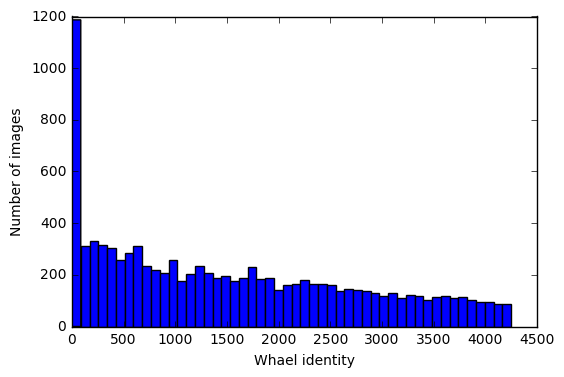

Statistics of the number of images per identity
Min: 1, Max: 810, Mean: 2.32, Median: 1


In [51]:
ids, labels = pd.factorize(id_column) # Convert the string arrays into unique ids with labels
plt.hist(ids, bins=50, color="blue") # Plot the histogram representing the number of images vs whale identities
ax = plt.gca()
ax.set_xlabel("Whael identity")
ax.set_ylabel("Number of images")
plt.show()
print("Statistics of the number of images per identity")
print("Min: %d, Max: %d, Mean: %.2f, Median: %d"
      %(np.min(val_counts), np.max(val_counts), np.mean(val_counts), np.median(val_counts)))


From this, we see that most of them only have 1 to 2 example images.

### Distribution of image sizes

Next, lets see the variety of image sizes (both in terms of width and height and also channel since there are also grayscale images in the set).

In [85]:
import os
file_names = os.listdir("train")
gray_img_counts = 0
sizes = np.zeros([len(file_names), 2])
for i, name in enumerate(file_names):
    img = plt.imread("train\\"+name)
    if(len(img.shape) == 2): #Count the number of grayscale images
        gray_img_counts += 1
    sizes[i] = img.shape[:2]

Lets check the number of color and grayscale images.

In [86]:
print("Color images: %d, Grayscale images: %d" %(len(file_names) - gray_img_counts, gray_img_counts))

Color images: 8381, Grayscale images: 1469


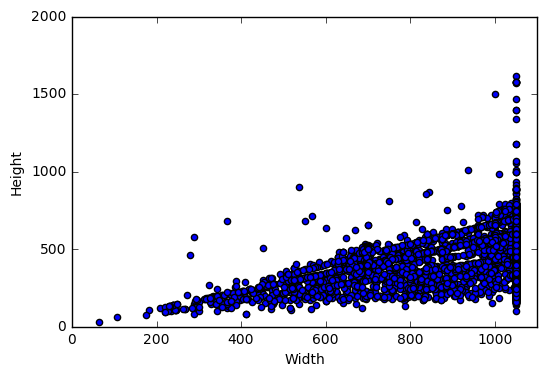

In [72]:
plt.scatter(sizes[:, 1], sizes[:, 0])
ax = plt.gca()
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_xlim([0, 1100])
ax.set_ylim([0, 2000])
plt.show()

### Explore features

Next, lets see some examples of images in the training set. The following two images are from the same whale but taken in different angles. From this, we know that appearances of the same fluke extremely differ when being seen from above and from underneath.


<img src="top.jpg" alt="Drawing" style="width: 500px;"/>
<img src="under.jpg" alt="Drawing" style="width: 500px;"/>

Thanks to this video on youtube: https://www.youtube.com/watch?v=fBGq85Q2198 for ensuring me that normally the back side will be darker than the front side.
Therefore, it should help if we separate fluke images into two cases: its back and its front. (I'll call the first image as its back)

#### Clustering

As we have seen the data comes in a huge variety in terms of appearance of whales and sizes, scenes and so on. Now, its time for the labor intensive work! data cleaning. However, as I only have 2 days to do the task, I will not do much labor work but would rather automate it.

Firstly, I would like to separate the data into two groups, namely, front images and back images of flukes. To achieve this, I try to cluster the images with the following procedures:
* Preprocess each image by resizing it to 224x224 (with preserved ratio, this is achieved by zero padding)
* Use ResNet50 (with added global average pooling layer to the end) with pretrained weights on ImageNet to embed each preprocessed image in the training set (2,048-dimension vector).
* Perform N times, the following procedures:
    * Cluster the images using K-mean clustering with 2 clusters
    * Observe the images in each cluster and perform clustering again (with 2 clusters) on the cluster that looks better
    * Do this N times until the resulting clusters contain mostly images of one side of flukes

The process is describeed in the following image:
<table class="image">
    <caption align="bottom" style="width: 750px;">I iteratively do binary clustering image (based on their embedded vectors) until groups of front and back view images are roughly separated.</caption>
    <img src="hierarchical_clustering.png" alt="Drawing" style="width: 1000px;"/>
</table>

After doing clustering for 3 times as in the previous image, I get the following group of images:

<table class="image">
    <caption align="bottom" style="width: 500px;">Images from the first group. Most of the images seem to be the front views of flukes</caption>
    <img src="front-images.png" alt="Drawing" style="width: 500px;"/>
</table>
<table class="image">
    <caption align="bottom" style="width: 500px;">Images from the second group. Most of the images seem to be the back views of flukes</caption>
    <img src="back-images.png" alt="Drawing" style="width: 500px;"/>
</table>

#### Histogram analysis (1D)

After we roughly get a group of back and front images, we can see that most distinctive features between the two set of images are the color infomration. Lets see the distribution of their colors with the following code:

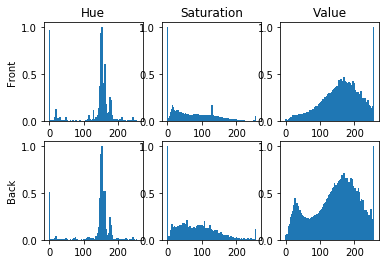

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

## In this code snippet we model the color distribution of images of the front view and the back view of flukes
# Define the number of random samples
num_samples = 500
# Array for accumulate occurences of values of each channel
sum_front = np.zeros([3, 256])
sum_back = np.zeros([3, 256])

# Get images names and sample perform random sampling
front_names = os.listdir("temp_images\\front")
front_inds = np.arange(len(front_names))
np.random.shuffle(front_inds)
back_names = os.listdir("temp_images\\back")
back_inds = np.arange(len(back_names))
np.random.shuffle(back_inds)

# Accumulate values from each random sampled image from each group
for i in range(num_samples):
    ## Keep summing up values in S and V channels of front view images
    # Load random samples from the front view images and convert to HSV color space
    img_front = cv2.imread("temp_images\\front\\"+front_names[front_inds[i]])
    img_front = cv2.cvtColor(img_front, cv2.COLOR_BGR2HSV)
    # Calculate and sum histogram for each channel H, S, V
    sum_front[0, :] += np.histogram(img_front[:, :, 0].ravel(), bins=256)[0]
    sum_front[1, :] += np.histogram(img_front[:, :, 1].ravel(), bins=256)[0]
    sum_front[2, :] += np.histogram(img_front[:, :, 2].ravel(), bins=256)[0]
    
    ## Keep summing up values in S and V channels of back view images
    # Load random samples from the back view images and convert to HSV color space
    img_back = cv2.imread("temp_images\\back\\"+back_names[back_inds[i]])
    img_back = cv2.cvtColor(img_back, cv2.COLOR_BGR2HSV)
    # Calculate and sum histogram for each channel H, S, V
    sum_back[0, :] += np.histogram(img_back[:, :, 0].ravel(), bins=256)[0]
    sum_back[1, :] += np.histogram(img_back[:, :, 1].ravel(), bins=256)[0]
    sum_back[2, :] += np.histogram(img_back[:, :, 2].ravel(), bins=256)[0]

# Plot the histogram
fig, ax = plt.subplots(nrows=2, ncols=3)
axs = ax.ravel()

# Calculate centers and widths of each bar in a bar plot
bins = np.arange(257)
width = 5*(bins[1] - bins[0])
center = (bins[1:]+bins[:-1]) / 2

# Normalize the summed histogram values for front view images
front_max = np.max(sum_front, axis=1)
sum_front[0] /= front_max[0]
sum_front[1] /= front_max[1]
sum_front[2] /= front_max[2]

# Normalize the summed histogram values for back view images
back_max = np.max(sum_back, axis=1)
sum_back[0] /= back_max[0]
sum_back[1] /= back_max[1]
sum_back[2] /= back_max[2]

# Plot histogram of each channel for front view images
axs[0].bar(center, sum_front[0, :], align='center', width=width)
axs[1].bar(center, sum_front[1, :], align='center', width=width)
axs[2].bar(center, sum_front[2, :], align='center', width=width)

# Plot histogram of each channel for back view images
axs[3].bar(center, sum_back[0, :], align='center', width=width)
axs[4].bar(center, sum_back[1, :], align='center', width=width)
axs[5].bar(center, sum_back[2, :], align='center', width=width)

# Set labels and show
axs[0].set_ylabel("Front")
axs[3].set_ylabel("Back")

axs[0].set_title("Hue")
axs[1].set_title("Saturation")
axs[2].set_title("Value")

plt.show()

I use HSV color space here for better separation of colorness and brightness values. Obviously, we see that the value channel (V channel of HSV color space) is the most distinctive feature and saturation channel is also good.

For the back images, the histogram of V channel is bimodal. I'm quite sure the peak with low V values are those pixels from the fluke (since it a huge black area in the images). Also, it seems back view images have more saturation than front view ones.

#### Histogram analysis (2D)

We might be able to use these information to classify images into back and front view first before we do the identification. Lets see some more histogram analysis with the combined information from two channels S and V.

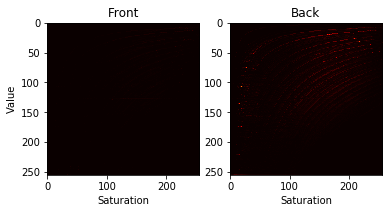

In [19]:
import matplotlib.colors as colors
## In this code snippet we model the color distribution of images of the front view and the back view of flukes
# Define the number of random samples
num_samples = 500
# Array for accumulate occurences of values of each channel
sum_front = np.zeros([256, 256])
sum_back = np.zeros([256, 256])

# Get images names and sample perform random sampling
front_names = os.listdir("temp_images\\front")
front_inds = np.arange(len(front_names))
np.random.shuffle(front_inds)
back_names = os.listdir("temp_images\\back")
back_inds = np.arange(len(back_names))
np.random.shuffle(back_inds)

# Accumulate values from each random sampled image from each group
for i in range(num_samples):
    ## Keep summing up values in S and V channels of front view images
    # Load random samples from the front view images and convert to HSV color space
    img_front = cv2.imread("temp_images\\front\\"+front_names[front_inds[i]])
    img_front = cv2.cvtColor(img_front, cv2.COLOR_BGR2HSV)
    # Get each channel flatten
    S_channel = img_front[:, :, 1].ravel()
    V_channel = img_front[:, :, 2].ravel()
    # Calculate 2d histogram and sum
    sum_front += np.histogram2d(S_channel, V_channel, bins=[256, 256])[0]

    ## Keep summing up values in S and V channels of back view images
    # Load random samples from the back view images and convert to HSV color space
    img_back = cv2.imread("temp_images\\back\\"+back_names[back_inds[i]])
    img_back = cv2.cvtColor(img_back, cv2.COLOR_BGR2HSV)    
    # Get each channel flatten
    S_channel = img_back[:, :, 1].ravel()
    V_channel = img_back[:, :, 2].ravel()
    # Calculate 2d histogram and sum
    sum_back += np.histogram2d(S_channel, V_channel, bins=[256, 256])[0]


# Plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=2)
axs = ax.ravel()

sum_front = sum_front / np.max(sum_front) # normalize the values 
sum_back = sum_back / np.max(sum_back) # normalize the values 

axs[0].imshow(sum_front, cmap='hot', interpolation="nearest")
axs[1].imshow(sum_back, cmap='hot', interpolation="nearest")

# Set labels and show
axs[0].set_xlabel("Saturation")
axs[0].set_ylabel("Value")
axs[1].set_xlabel("Saturation")

axs[0].set_title("Front")
axs[1].set_title("Back")

plt.show()

Well, it is quite hard to see something here. Lets put in log normalization for easier visualization.

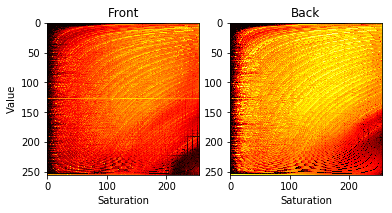

In [20]:
# Plot the histogram
fig, ax = plt.subplots(nrows=1, ncols=2)
axs = ax.ravel()

sum_front = sum_front / np.max(sum_front) + 0.000001 # Add small value so the min value is not zero (for LogNorm visualization)
sum_back = sum_back / np.max(sum_back) + 0.000001

axs[0].imshow(sum_front, cmap='hot', interpolation="nearest",
              norm=colors.LogNorm(vmin=sum_front.min(), vmax=sum_front.max()),) # Use LogNorm for better visualization
axs[1].imshow(sum_back, cmap='hot', interpolation="nearest",
              norm=colors.LogNorm(vmin=sum_back.min(), vmax=sum_back.max()),) # Use LogNorm for better visualization

# Set labels and show
axs[0].set_xlabel("Saturation")
axs[0].set_ylabel("Value")
axs[1].set_xlabel("Saturation")

axs[0].set_title("Front")
axs[1].set_title("Back")

plt.show()

## Model

Once we sufficiently know our data, it's time to create our model!

### Ideas

Since this is not a common classification, rather it is a one-shot learning problem, I would go with siamese network approach. I would use ResNet50 and perform transfer learning to estimate a similarity function between a chosen pair of whales.


<table class="image">
    <caption align="bottom" style="width: 200px;">Overview of the model</caption>
    <img src="overall.png" alt="Drawing" style="width: 900px;"/>
</table>

#### Preprocessing

Steps in preprocessing are as follows:
* Resize the image so that the bigger dimension is equal to 224
* Pad the smaller dimension to make it square (224x224)
* 224x224 is used for the sake of my GPU's memory and also to be identical to the input shape of the pretrained ResNet

#### Network architecture

As stated, I choose ResNet50 to be the base model and added to the top a <i>global average pooling</i> (GAP) layer to reduce dimenison. It is then followed by a layer which calculates the distance between Image A and B. The last layer is then added to calculate the similarity socre with <i>sigmoid</i> activation function.

As seen in the <i>explore features</i> section, the same whale might be photographed in different view and this would result in a highly dissimilar images. I would like to find some way to cope with this and use the view information to help in identification.

I have tried:
* Using 2D histogram constructed from S and V channels of HSV color space of an image as a feature to train a neural network for view classification. <strong>FAIL</strong>: since it only gets around 70% on validation data.
* Use the learned K-mean clustering in the <i>clustering</i> section to predict whether an image is a front/back view. <strong>Seems OK</strong>

The final network ended up being as in the following image.

<table class="image">
    <caption align="bottom" style="width: 200px;">Overview of the final model</caption>
    <img src="overall2.png" alt="Drawing" style="width: 900px;"/>
</table>

The code for the network in Keras is as follows:

In [ ]:
def identification_model(image_shape, model_num, weight_path=None):
    with tf.device("/cpu:0"):
        # Define model
        ## Define inputs with predefined shape (in this case [224, 224, 3])
        img = Input(shape=image_shape)
        img1 = Input(shape=image_shape)
        img2 = Input(shape=image_shape)
        
        # Based model is ResNet50 with additional GAP layer at the end for dimension reduciton
        resnet = ResNet50(include_top=False)
        baseModel = Model(inputs=[img],
                          outputs=GlobalAveragePooling2D()(resnet(img)))
        
        # Get embedding of each image from the based model
        embedded_img1 = baseModel(img1)
        embedded_img2 = baseModel(img2)

        # Layer which calculates L1 distance between a pair of vectors
        L1_layer = Lambda(lambda embeded_pair: tf.abs(embeded_pair[0] - embeded_pair[1]))
        
        # Reduce dimension and scale values to [0, 1] (same scale as view predictions)
        fc1_1 = Activation("sigmoid")(BatchNormalization()(Dense(128)(embedded_img1)))
        fc1_2 = Activation("sigmoid")(BatchNormalization()(Dense(128)(embedded_img2)))

        # Concatenate the embeddings with their view predictions
        ##  View prediction is just one value indicating whether the image is a front/back view of a whale
        view1 = Input(shape=[1])
        view2 = Input(shape=[1])
        
        # Concatenate view prediction with the obtained 128-dim vector to make 129-dim vector for each image
        merged1 = concatenate([fc1_1, view1])
        merged2 = concatenate([fc1_2, view2])

        # Reduce dimension to 32-dimension vectors
        ## This is for more complex transformation of view information and also to further reduce dimension
        fc2_1 = Activation("sigmoid")(BatchNormalization()(Dense(32)(merged1)))
        fc2_2 = Activation("sigmoid")(BatchNormalization()(Dense(32)(merged2)))

        # Get the output tensor for L1 distance and feed it to the last output layer
        L1_distance = L1_layer([fc2_1, fc2_2])
        out = Dense(1, activation="sigmoid", kernel_initializer="glorot_uniform")(L1_distance)
        model = Model(inputs=[img1, img2, view1, view2], outputs=out)
        
        # If specified load pretrained weights
        if not weight_path is None:
            model.load_weights(weight_path)
            
    return model

#### Training

In training, we feed into the network a batch of samples from out training set as <strong>"Image A"</strong> from and another batch (with the same batch size) of randomly selected samples as <strong>"Image B"</strong>. The target values are then a binary vector where each element indicates whether a pair of samples has the same identity or not. Loss function used here is <i>binary crossentropy</i>.

Batches are drawn sequentially (from the training data) for <strong>"Image A"</strong> and for <strong>"Image B"</strong>, I draw them randomly as shown in the below image:

<table class="image">
    <caption align="bottom" style="width: 200px;">Batch generating process</caption>
    <img align:center src="generate_batch.png" alt="Drawing" style="width: 800px;"/>
</table>

Ground truth are obtained by comparing the Ids of samples for <strong>"Image A"</strong> and <strong>"Image B"</strong>
Please note that I already do the view prediction (using the last learned K-mean clustering from <i>clustering</i> section to cluster them into either group) and store them in a file in prior to training.

The following function is used to generate next batch of training data

In [21]:
# For speed, all data (variable data, annotation, view_prediction) are already loaded in memory
## data -- an array of all preprocessed images
## annotations -- a Pandas dataframe consisting of two columns, "Image" (image name) and "Id" (whale Id)
## view_predictions -- an array consisting of view (front/back) predictions of all images

def get_next_batch(data, annotation, view_predictions, current_index, batch_size):
    with tf.device("/cpu:0"):
        batch_size = min(batch_size, len(data) - current_index)
        ## Get next batch
        batch = data[current_index:current_index + batch_size, :]
        batch_view = view_predictions[current_index: current_index + batch_size]
        ## Get the other distinct random batch
        indices = np.arange(len(data))
        #Remove the current batch from the random sampled ones so no duplicates
        indices = np.delete(indices, np.arange(current_index, current_index+32,))
        np.random.shuffle(indices)
        random_batch = data[indices[:batch_size], :]
        random_batch_view = view_predictions[indices[:batch_size]]

        ## Process ground truth values
        ground_truth = np.zeros([batch_size])
        for i in range(batch_size):
            id = annotation["Id"][current_index+i]
            random_sample_id = annotation["Id"][indices[i]]
            if id == random_sample_id:
                ground_truth[i] = 1
                
    return batch, random_batch, ground_truth, batch_view, random_batch_view

## Evaluation

To evaluate the model in accordance with the competition, I use mean averaged precision (MAP) as a metric.
I separate the dataset of 9,850 samples into:
* 70% for training (6,895 samples) and
* 30% for testing (2,955 samples)